In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sklearn
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [54]:
df=pd.read_csv("spark_df.csv",parse_dates=['TimeStamp (UTC)'])
df_time=df.reset_index()

df['time_stamp']=df_time['TimeStamp (UTC)']
df['time_stamp']=pd.to_datetime(df['time_stamp'])
print(df.columns)
df.info()
df.columns
#df_time.info()

Index(['TimeStamp (UTC)', 'WindDirection Avg', 'WindSpeed Avg',
       'WindSpeed StdDev', 'T AMB Avg', 'In AirDensity Avg', 'time_stamp'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   TimeStamp (UTC)    8760 non-null   datetime64[ns, UTC]
 1   WindDirection Avg  6568 non-null   float64            
 2   WindSpeed Avg      8740 non-null   float64            
 3   WindSpeed StdDev   8625 non-null   float64            
 4   T AMB Avg          8740 non-null   float64            
 5   In AirDensity Avg  8469 non-null   float64            
 6   time_stamp         8760 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(5)
memory usage: 479.2 KB


Index(['TimeStamp (UTC)', 'WindDirection Avg', 'WindSpeed Avg',
       'WindSpeed StdDev', 'T AMB Avg', 'In AirDensity Avg', 'time_stamp'],
      dtype='object')

In [55]:


# scaling fucntions
def scaling(df):
    df.drop(columns=['time_stamp','TimeStamp (UTC)','WindSpeed StdDev'], inplace=True)
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)

    scaled_df=pd.DataFrame(scaled_df,columns= ['WindDirection Avg', 'WindSpeed Avg',
        'T AMB Avg', 'In AirDensity Avg'])
    return(scaled_df)
df_scaled=scaling(df)
df_scaled.corr()



,WindDirection Avg,WindSpeed Avg,T AMB Avg,In AirDensity Avg
WindDirection Avg,1.000000,0.163001,0.044950,-0.000111
WindSpeed Avg,0.163001,1.000000,-0.004208,-0.005539
T AMB Avg,0.044950,-0.004208,1.000000,-0.268851
In AirDensity Avg,-0.000111,-0.005539,-0.268851,1.000000


Except for windDirection, no other feaatures show significant correlation as per the correlation values above

<Axes: xlabel='WindDirection Avg', ylabel='WindSpeed Avg'>

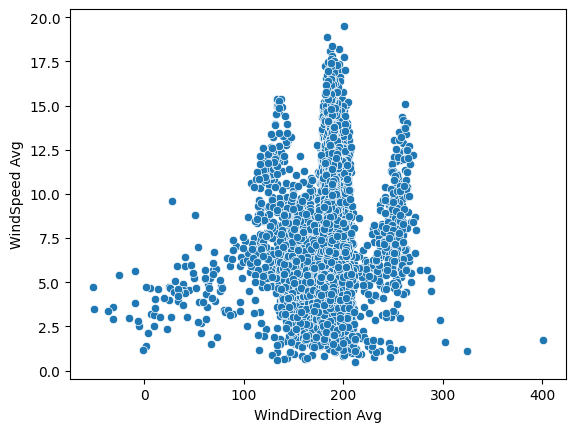

In [56]:

sns.scatterplot(data=df,x='WindDirection Avg',y='WindSpeed Avg')



In [57]:
import datetime
# df['time_stamp']=pd.to_datetime(df.time_stamp)
df.sample(10)


,WindDirection Avg,WindSpeed Avg,T AMB Avg,In AirDensity Avg
1980,202.086985,5.772706,19.292574,1.066705
659,184.457775,8.319817,7.154894,1.110274
8058,181.802706,6.902372,24.959466,1.047051
4707,263.899073,11.234868,23.569647,1.051960
7760,185.290905,9.352131,11.701030,1.092901
3239,183.996615,10.318475,19.177207,1.067907
1128,206.269284,12.222154,-1.363076,1.145433
8020,185.488739,5.104800,14.411716,1.082968
2548,154.446332,7.275083,6.626751,1.114312
6104,NaN,8.911499,21.174785,1.058847


Create a simple persiatnce model to compare loss metrics against more sophisticated models later

(8760,) (8760,)
df_pers columnsIndex(['WindDirection Avg', 'WindSpeed Avg', 'T AMB Avg', 'In AirDensity Avg',
       'WindSpeed_avg_scaled', 'time_stamp'],
      dtype='object')


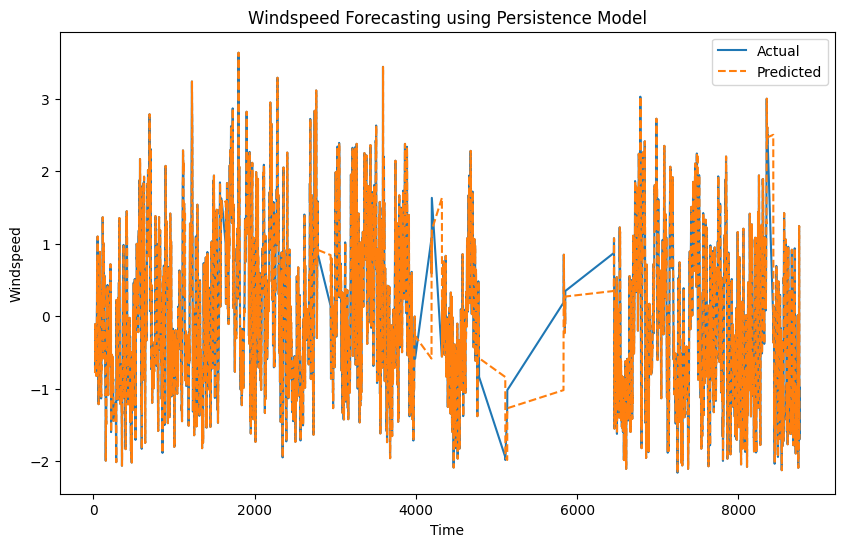

Root Mean Squared Error: 0.32461350002933975
Index(['WindDirection Avg', 'WindSpeed Avg', 'T AMB Avg', 'In AirDensity Avg',
       'WindSpeed_avg_scaled'],
      dtype='object')


In [58]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


scaler=StandardScaler()
df['WindSpeed_avg_scaled']=scaler.fit_transform(df['WindSpeed Avg'].values.reshape(-1, 1))
print(df['WindSpeed Avg'].shape,df['WindSpeed_avg_scaled'].shape)
# Drop NaN values
df.dropna(inplace=True)

# Persistence model prediction as baseline (y[t+1]=y[t]) to compare error metrics: 
df_pers = df.copy()
df_pers['time_stamp']=df_time['TimeStamp (UTC)']

print(f"df_pers columns{df_pers.columns}")

# df_pers['windspeedAvg_naive_pred'] = df_pers['WindSpeed Avg'].shift(1)
df_pers['WindSpeed_avg_scaled_naive_pred']=df_pers['WindSpeed_avg_scaled'].shift(1)
# Drop the row with NaN value
df_pers.dropna(inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(df_pers.index, df_pers['WindSpeed_avg_scaled'], label='Actual')
plt.plot(df_pers.index, df_pers['WindSpeed_avg_scaled_naive_pred'], label='Predicted', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Windspeed')
plt.title('Windspeed Forecasting using Persistence Model')
plt.legend()
plt.show()

# Filter the DataFrame for the test set
df_pers_test = df_pers.loc[df_pers.time_stamp > '2021/08/02']


rmse_scaled=np.sqrt(mean_squared_error(df_pers_test['WindSpeed_avg_scaled'], df_pers_test['WindSpeed_avg_scaled_naive_pred']))
print(f'Root Mean Squared Error: {rmse_scaled}')
print(df.columns)

In [59]:
##Generate timeseries based features for the model along with wind direction feature already identified
import datetime as dt
df['time_stamp']=df_time['TimeStamp (UTC)']
df['time_stamp']=pd.to_datetime(df.time_stamp)
def create_features(df):
    # df=df.reset_index()
    df['day']=df['time_stamp'].dt.day
    df['month']=df['time_stamp'].dt.month
    df['year']=df['time_stamp'].dt.year
    df['hour']=df['time_stamp'].dt.hour
    df['dayOfYear'] = df['time_stamp'].dt.dayofyear
    df['weekOfYear'] = df['time_stamp'].dt.isocalendar().week   
    return(df[['time_stamp','year','month','day','hour','dayOfYear','weekOfYear','WindDirection Avg','WindSpeed Avg']])

df=create_features(df)
df.sample(5)

,time_stamp,year,month,day,hour,dayOfYear,weekOfYear,WindDirection Avg,WindSpeed Avg
465,2021-01-20 15:00:00+00:00,2021,1,20,15,20,3,151.860657,1.475095
3364,2021-05-21 10:00:00+00:00,2021,5,21,10,141,20,184.774160,13.837701
879,2021-02-06 21:00:00+00:00,2021,2,6,21,37,5,201.161507,8.018004
4774,2021-07-19 04:00:00+00:00,2021,7,19,4,200,29,259.909398,8.288125
8142,2021-12-06 12:00:00+00:00,2021,12,6,12,340,49,160.156312,11.287728


Index(['year', 'month', 'day', 'hour', 'dayOfYear', 'weekOfYear',
       'WindDirection Avg', 'WindSpeed Avg', 'WindDirection Avg_scaled',
       'WindSpeed_avg_scaled'],
      dtype='object')


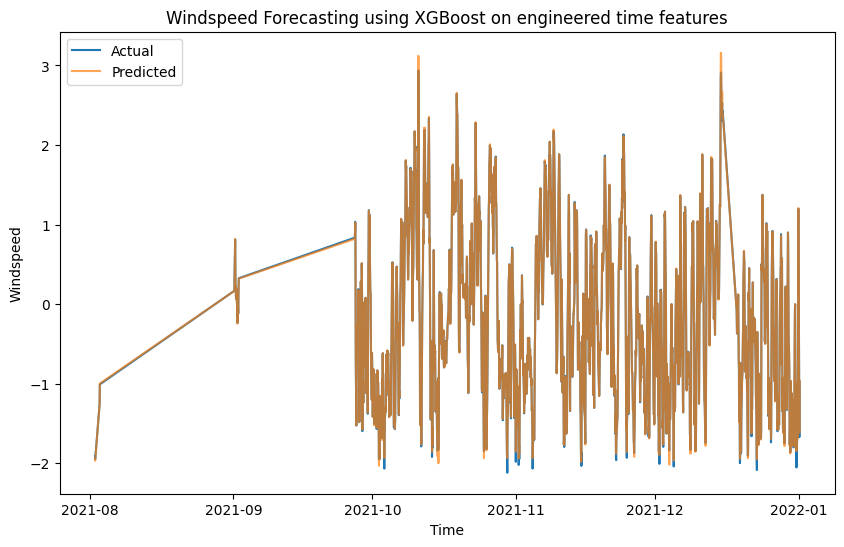

Root Mean Squared Error: 0.020343160592759486


In [60]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


df.dropna(inplace=True)
# print(df.time_stamp.min(),df.time_stamp.max())

##Persistance model prediciton as baseline to compare error metrics

df.set_index('time_stamp',inplace=True)
df['WindDirection Avg_scaled']=scaler.fit_transform(df['WindDirection Avg'].values.reshape(-1, 1))
df['WindSpeed_avg_scaled']=scaler.fit_transform(df['WindSpeed Avg'].values.reshape(-1, 1))
print(df.columns)

# Split the data into training and testing sets
X = df.drop(columns=['WindSpeed Avg','WindDirection Avg'])
X_train=X.loc[df.index<'2021/08/02']
y = df['WindSpeed_avg_scaled']
y_train=y.loc[df.index<'2021/08/02']

X_test=X.loc[df.index>'2021/08/02']
y_test=y.loc[df.index>'2021/08/02']


# Train the XGBoost model
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

# Make predictions
y_pred = model.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Windspeed')
plt.title('Windspeed Forecasting using XGBoost on engineered time features')
plt.legend()
plt.show()

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Create a XGboost model using time lag features alone

Index(['WindSpeed Avg', 'time_stamp'], dtype='object')
Index(['WindSpeed Avg', 'WindSpeed_avg_scaled', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31',
       'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
       'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
       'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51', 'lag_52',
       'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57', 'lag_58', 'lag_59',
       'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64', 'lag_65', 'lag_66',
       'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_72', 'lag_73',
       'lag_74', 'lag_75', 'lag_76', 'lag_77', 'lag_78', 'lag_79', 'lag_80',
       'lag_81', 'lag_82', 'l

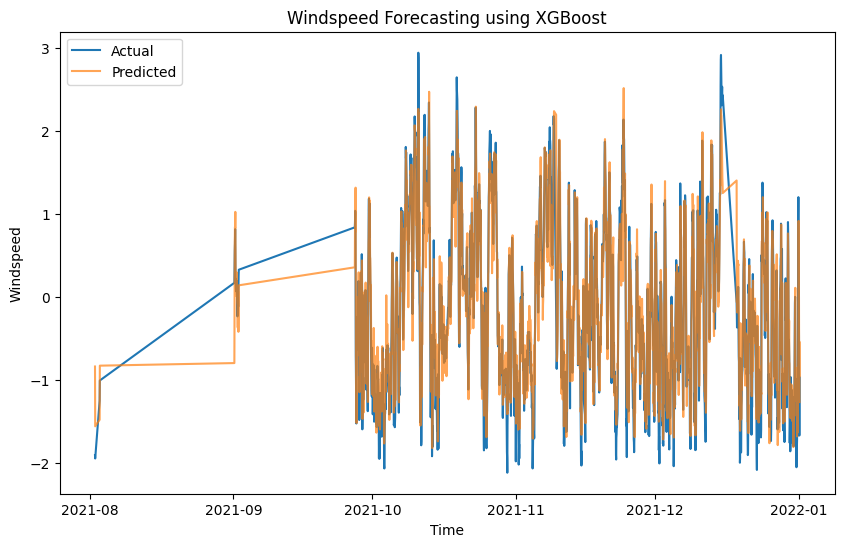

Root Mean Squared Error: 0.020343160592759486


In [61]:
##### Create a XGboost model using time lag features alone
# # Create lag features

df2=df[['WindSpeed Avg']]
df2['time_stamp']=df.index
print(df2.columns)
df2['WindSpeed_avg_scaled']=scaler.fit_transform(df2['WindSpeed Avg'].values.reshape(-1, 1))
for i in range(1, 99):
    df2[f'lag_{i}'] = df2['WindSpeed_avg_scaled'].shift(i)

df2.dropna(inplace=True)
# print(df.time_stamp.min(),df.time_stamp.max())

df2.set_index('time_stamp',inplace=True)

print(df2.columns)

# Split the data into training and testing sets
X = df2.drop(columns=['WindSpeed Avg','WindSpeed_avg_scaled'])
X_train=X.loc[df2.index<'2021/08/02']
y = df2['WindSpeed_avg_scaled']
y_train=y.loc[df2.index<'2021/08/02']

X_test=X.loc[df2.index>'2021/08/02']
y_test=y.loc[df2.index>'2021/08/02']


# Train the XGBoost model
model2 = xgb.XGBRegressor(n_estimators=1000)
model2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

# Make predictions
y_pred = model2.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Windspeed')
plt.title('Windspeed Forecasting using XGBoost')
plt.legend()
plt.show()

# Calculate and print RMSE
rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


##Root Mean Squared Error: 0.0203 obtained with XGBOOST and time lag features is the best error metric among three model that were tried out:
1) Persistance model (Y[t+1]=Y[t])
2) Xgboost using engineered features and WindDirection
3) Xgbost using time lag features
4) ARIMA foreacting (tried below)


Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
       'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29',
       'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36',
       'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43',
       'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50',
       'lag_51', 'lag_52', 'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57',
       'lag_58', 'lag_59', 'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64',
       'lag_65', 'lag_66', 'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71',
       'lag_72', 'lag_73', 'lag_74', 'lag_75', 'lag_76', 'lag_77', 'lag_78',
       'lag_79', 'lag_80', 'lag_81', 'lag_82', 'lag_83', 'lag_84', 'lag_85',
       'lag_86', 'lag_87', 'lag_88', 'lag_89', 'lag_90', 'lag_91', 'lag_92'

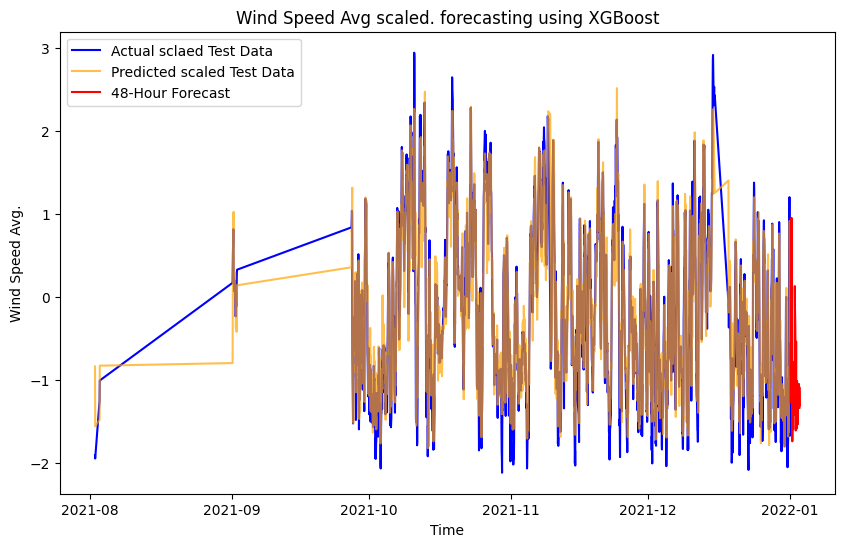

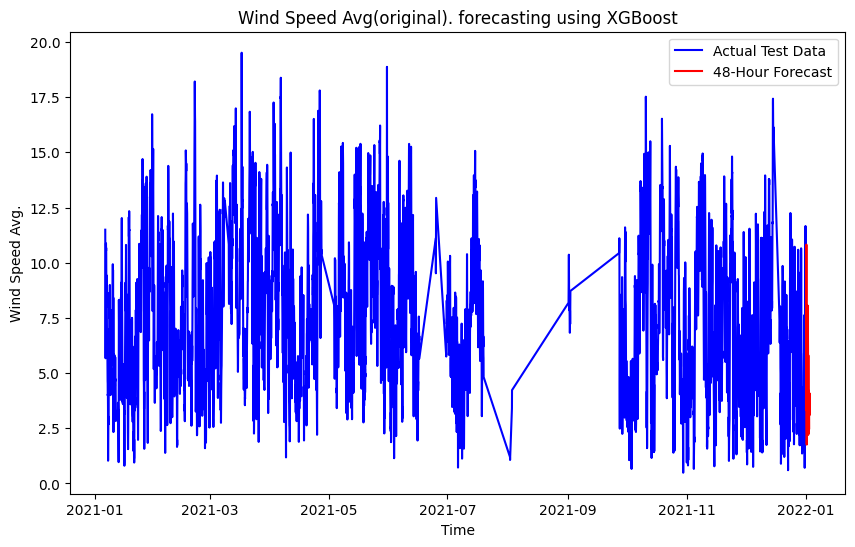

(48,)


In [62]:
##forecasting using XGBOOST algorithm and time lag features 

# Forecast for the next 48 hours
forecast_horizon = 48
forecast = []
print(X_test.columns)
last_observation = X_test.iloc[-1].values.reshape(1, -1)

for _ in range(forecast_horizon):
    next_pred = model2.predict(last_observation)
    forecast.append(next_pred[0])
    
    new_row = np.roll(last_observation, -1)
    # new_row[0, -1] = scaler.transform(np.array([[next_pred[0]]]))[0, 0]
    new_row[0, -1] = np.array([[next_pred[0]]])[0, 0]
    last_observation = new_row.reshape(1, -1)

# Create DataFrame with forecasted values
forecast_index = pd.date_range(start=X_test.index[-1], periods=forecast_horizon, freq='H')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the test data & forecasted data on the same plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual sclaed Test Data', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted scaled Test Data', color='orange', alpha=0.7)
plt.plot(forecast_series.index, forecast_series, label='48-Hour Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Wind Speed Avg.')
plt.title('Wind Speed Avg scaled. forecasting using XGBoost')
plt.legend()
plt.show()

#Ortiginal WindSpeedAvg 

df2['WindSpeed_avg_original'] = scaler.inverse_transform(df2['WindSpeed_avg_scaled'].values.reshape(-1, 1))


forecast_unscaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()


unscaled_df = pd.concat([df2['WindSpeed_avg_original'], pd.Series(forecast_unscaled, index=forecast_series.index)], axis=0)

#Plot Original WindSpeedAvg. Signal
plt.figure(figsize=(10, 6))
plt.plot(df2.index,df2['WindSpeed_avg_original'], label='Actual Test Data', color='blue')
plt.plot(forecast_index,forecast_unscaled, label='48-Hour Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Wind Speed Avg.')
plt.title('Wind Speed Avg(original). forecasting using XGBoost')
plt.legend()
plt.show()

print(forecast_unscaled.shape)

In [63]:
#### TRY  CLASSICAL TIME SERIES METHODS like ARIMA. Cannot use yearly seasonal features as the given data contains only one years' data


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [65]:
df=pd.read_csv("spark_df.csv",parse_dates=['TimeStamp (UTC)'])
df_time=df.reset_index()

df['time_stamp']=df_time['TimeStamp (UTC)']
df['time_stamp']=pd.to_datetime(df['time_stamp'])
print(df.columns)
df.info()

Index(['TimeStamp (UTC)', 'WindDirection Avg', 'WindSpeed Avg',
       'WindSpeed StdDev', 'T AMB Avg', 'In AirDensity Avg', 'time_stamp'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   TimeStamp (UTC)    8760 non-null   datetime64[ns, UTC]
 1   WindDirection Avg  6568 non-null   float64            
 2   WindSpeed Avg      8740 non-null   float64            
 3   WindSpeed StdDev   8625 non-null   float64            
 4   T AMB Avg          8740 non-null   float64            
 5   In AirDensity Avg  8469 non-null   float64            
 6   time_stamp         8760 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(5)
memory usage: 479.2 KB


Index(['time_stamp', 'WindSpeed Avg'], dtype='object')
ADF Statistic: -11.046094689586853
p-value: 5.21872064596628e-20
-11.046094689586853 5.21872064596628e-20


<Axes: xlabel='index', ylabel='WindSpeed Avg'>

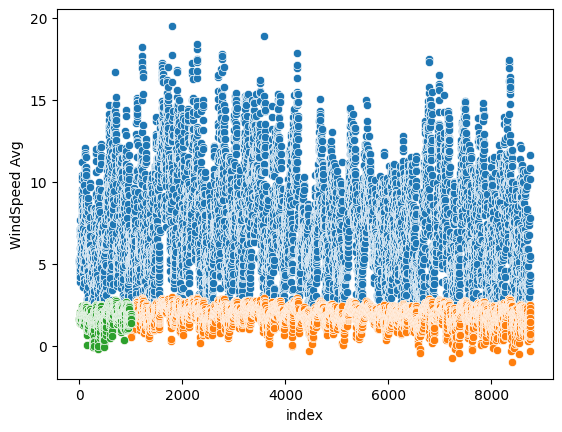

In [66]:

df=df[['time_stamp','WindSpeed Avg']]
print(df.columns)
df['WindSpeed Avg']=pd.to_numeric(df['WindSpeed Avg'],errors='coerce')
df = df.reset_index()
sns.scatterplot(data=df,x='index',y='WindSpeed Avg')

df['log_WindSpeed']=np.log(df['WindSpeed Avg'])
sns.scatterplot(data=df,x='index',y='log_WindSpeed')

# log_df=np.log(df)

def adf_check(df):
    
    adf_result = adfuller(df)
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    return(adf_result[0],adf_result[1])

# viz1 = seasonal_decompose(df[:10000], model='additive', period=8760)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df=df.dropna(how='any')

adf_viz1 = adf_check(df['log_WindSpeed'][:10000])
print(adf_viz1[0],adf_viz1[1])


sns.scatterplot(data=df.head(1000),x="index",y='log_WindSpeed')

ADF Statistic: -11.519485960782292
p-value: 4.0729398198051485e-21
-11.519485960782292 4.0729398198051485e-21


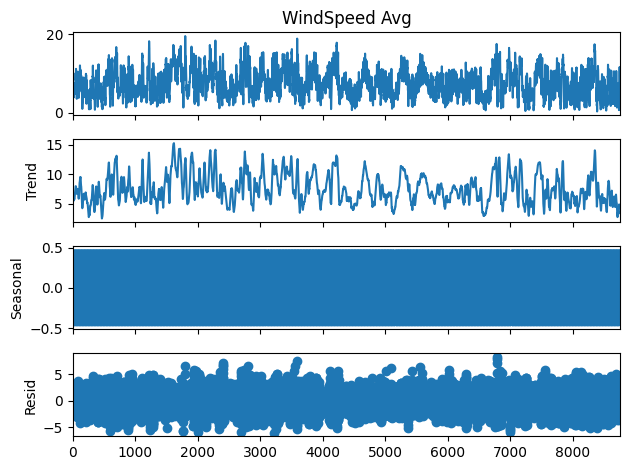

In [67]:
###Check and confirm stationarity

def adf_check(df):
    df=df.dropna()
    adf_result = adfuller(df['WindSpeed Avg'])
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    return(adf_result[0],adf_result[1])


adf_viz = adf_check(df)
print(adf_viz[0],adf_viz[1])
df=df.dropna(how='any')
df_decomposed= seasonal_decompose(df['WindSpeed Avg'], model='additive', period=24)
df_decomposed.plot()
plt.show()

In [68]:
df.columns

Index(['index', 'time_stamp', 'WindSpeed Avg', 'log_WindSpeed'], dtype='object')

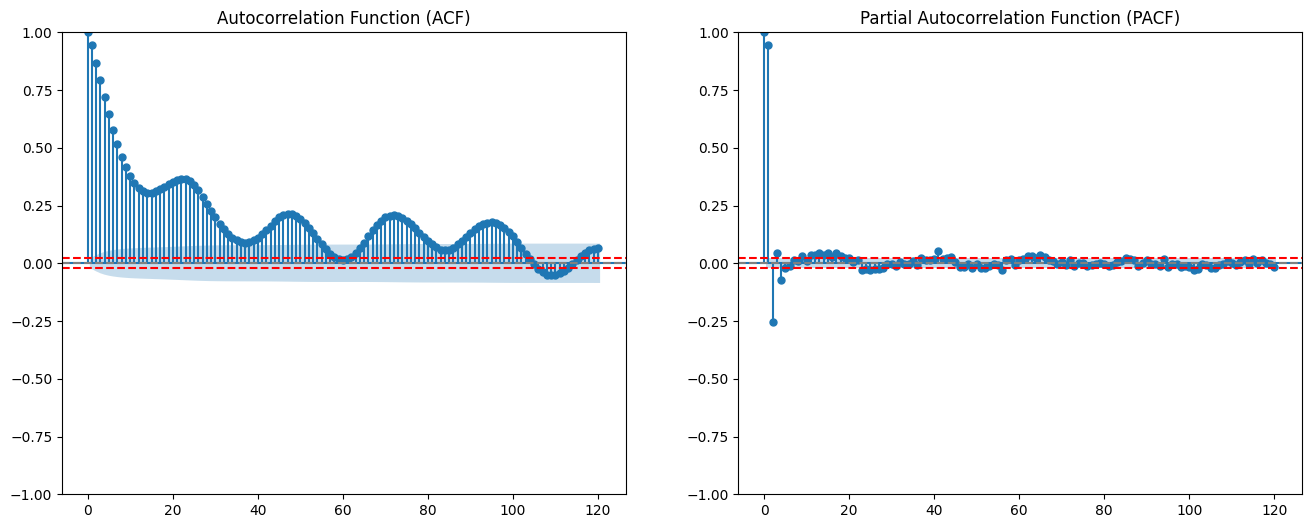

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
def plot_acf_pacf(df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    df=df.dropna(how='any')
    # Plot ACF
    plot_acf(df['WindSpeed Avg'], ax=axes[0],lags=120)
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[0].axhline(y=0, linestyle='--', color='gray')
    axes[0].axhline(y=1.96/np.sqrt(len(df['WindSpeed Avg'])), linestyle='--', color='red')
    axes[0].axhline(y=-1.96/np.sqrt(len(df['WindSpeed Avg'])), linestyle='--', color='red')

    # Plot PACF
    plot_pacf(df['WindSpeed Avg'], ax=axes[1],lags=120)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    axes[1].axhline(y=0, linestyle='--', color='gray')
    axes[1].axhline(y=1.96/np.sqrt(len(df['WindSpeed Avg'])), linestyle='--', color='red')
    axes[1].axhline(y=-1.96/np.sqrt(len(df['WindSpeed Avg'])), linestyle='--', color='red')

    plt.show()

# results show that the log_df_diff is still non stationary
plot_acf_pacf(df)

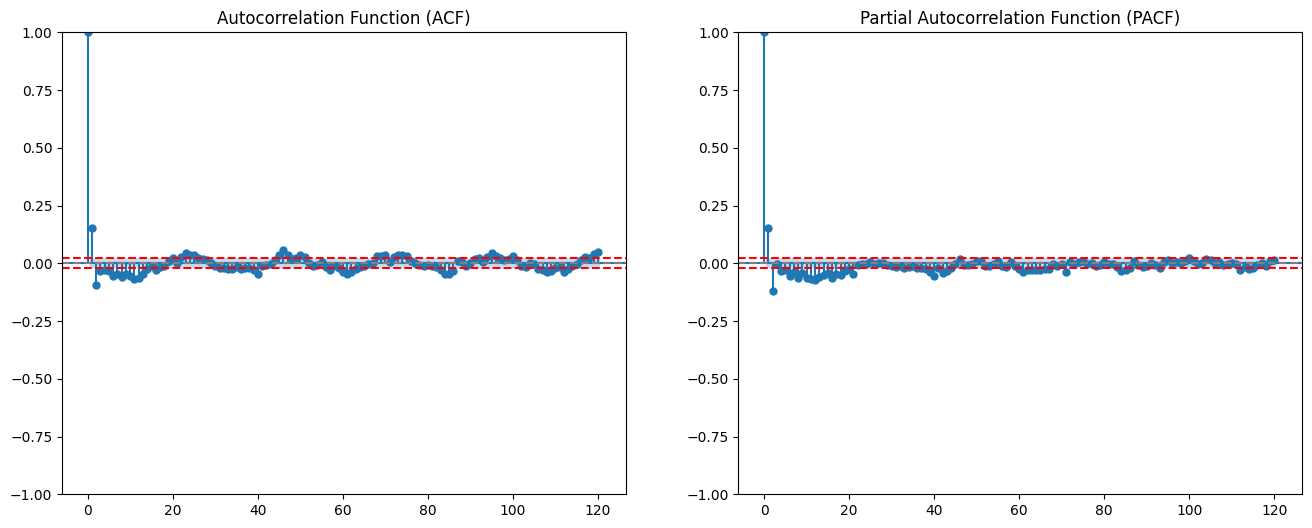

In [70]:
df['log_df_WindSpeed_diff1']=df['log_WindSpeed'].diff(1)
df=df.dropna(how='any')
fig,axes=plt.subplots(1,2,figsize=(16,6))

plot_acf(df['log_df_WindSpeed_diff1'],ax=axes[0],lags=120)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].axhline(y=0, linestyle='--', color='gray')
axes[0].axhline(y=1.96/np.sqrt(len(df['log_df_WindSpeed_diff1'])), linestyle='--', color='red')
axes[0].axhline(y=-1.96/np.sqrt(len(df['log_df_WindSpeed_diff1'])), linestyle='--', color='red')

plot_pacf(df['log_df_WindSpeed_diff1'],ax=axes[1],lags=120)
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].axhline(y=0, linestyle='--', color='gray')
axes[1].axhline(y=1.96/np.sqrt(len(df['log_df_WindSpeed_diff1'])), linestyle='--', color='red')
axes[1].axhline(y=-1.96/np.sqrt(len(df['log_df_WindSpeed_diff1'])), linestyle='--', color='red')

In [71]:
##from ACF,PACF plots: p=2,q=2,d=1. Check AIC values later

Index(['index', 'time_stamp', 'WindSpeed Avg', 'log_WindSpeed',
       'log_df_WindSpeed_diff1'],
      dtype='object')
                                 SARIMAX Results                                  
Dep. Variable:     log_df_WindSpeed_diff1   No. Observations:                  180
Model:                     ARIMA(2, 1, 2)   Log Likelihood                 -34.356
Date:                    Wed, 05 Feb 2025   AIC                             78.713
Time:                            22:37:39   BIC                             94.650
Sample:                                 0   HQIC                            85.175
                                    - 180                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2784      0.365      0.763      0.445    

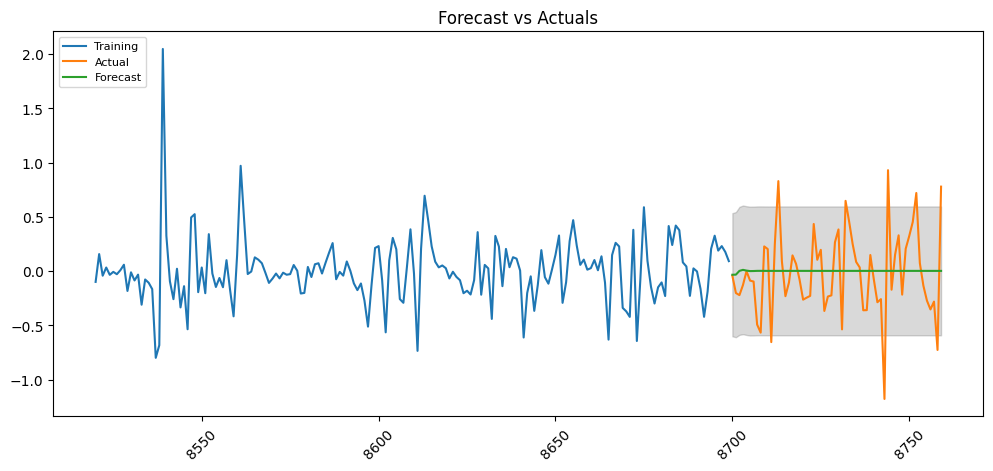

Root Mean Squared Error: 0.3898111151767703


In [72]:
###Test the error metric for the ARIMA model picked from ACF and PACF plots

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
print(df.columns)  # Just to display the columns)

# Check the accuracy of ARIMA prediction on actual data
train = df['log_df_WindSpeed_diff1'][-240:-60]
test = df['log_df_WindSpeed_diff1'][-60:]

# Fit the ARIMA model
model = ARIMA(train, order=(2, 1, 2))
fitted = model.fit()
print(fitted.summary())

# Forecast
#fc, se, conf = fitted.forecast(60, alpha=0.05)  # 95% confidence interval
fc, se, conf_lower, conf_upper = fitted.get_forecast(steps=60).summary_frame(alpha=0.05).T.values
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf_lower, index=test.index)
upper_series = pd.Series(conf_upper, index=test.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

rmse = np.sqrt(mean_squared_error(df['log_df_WindSpeed_diff1'][-60:], fc_series))
print(f'Root Mean Squared Error: {rmse}')

In [73]:
###RMSE score is the best for forecasting with lagged features of windspeed_avg using time lag features (Option 2). For ARIMA prediction accuracy is lower than that of simple persistance model